### Project 2: Physics-Informed Clustering and Expert Models for Ocean Mixing

## 1. Introduction

Accurately representing upper ocean mixing is essential for improving the performance of ocean and climate models. These small-scale processes govern the vertical transport of momentum, heat, and tracers, influencing everything from sea surface temperature to global circulation patterns. However, simulating these processes directly in large-scale models is computationally expensive, so they are commonly parameterized.

Sane et al. (2023) demonstrated a novel approach to parameterizing vertical mixing by predicting shape functions \( g(\sigma) \) with neural networks (NNs), trained on output from a one-dimensional turbulence model. While this method improved upon fixed functional forms (e.g., the universal shape function), it applied a single model across all physical conditions.

This raises a central question for our project:

> **Is a single shape function sufficient to represent upper ocean mixing under all physical regimes?**

We hypothesize that physical conditions such as latitude, wind stress, and surface buoyancy flux significantly influence the vertical structure of mixing. Therefore, a one-size-fits-all model may not capture the diversity of behaviors in the ocean surface boundary layer.

To address this, we explored two complementary strategies:

- **Clustering the dataset based on physical or shape characteristics**, and training specialized NNs for each group
- **Separately modeling shape functions at each depth level**, using dedicated NNs for each node

An initial analysis of physical drivers such as heat flux and latitude revealed distinct structural patterns in the data. These insights motivated a more granular modeling approach, taking into account both physical and depth-specific variability.

Together, these approaches form a flexible and interpretable framework for improving the representation of vertical mixing in climate models. In the following sections, we describe our dataset, methods, results, and key insights.


## 2. Dataset & Preprocessing

We use a publicly accessible dataset generated by the General Ocean Turbulence Model (GOTM), which simulates vertical mixing under a variety of physical forcing scenarios. Each sample includes a set of surface forcing variables and an associated shape function \( g(\sigma) \), defined over 16 normalized depth levels.

Our goal is to explore how different physical conditions affect the vertical structure of mixing and how specialized models can improve predictions of \( g(\sigma) \).


In [9]:
import numpy as np
import xarray as xr

# Load GOTM dataset from zarr store
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})


We focus on the following input features:

- **Coriolis parameter** (\( f \)): reflects rotational effects due to latitude
- **Surface buoyancy flux** (\( B_0 \)): represents convective forcing
- **Friction velocity** (\( u_* \)): related to wind-driven shear stress
- **Boundary layer depth** (\( h \)): depth of the surface mixing layer

The output is the shape function \( g(\sigma) \), pre-normalized across 16 vertical levels.


In [10]:
# Extract input features
l0 = d['l'].values.flatten()
b00 = d['b0'].values.flatten()
ustar0 = d['ustar'].values.flatten()
h0 = d['h'].values.flatten()

# Extract shape functions
SF = d['SF'].values  # shape (n_samples, 16)

# Combine inputs
X = np.stack([l0, b00, ustar0, h0], axis=1)

# Normalize shape functions by row-wise max
SF_norm = SF / np.max(SF, axis=1, keepdims=True)


To focus on physically meaningful scenarios, we filter out extreme values based on heat flux, wind stress, and boundary layer depth, following prior work.


In [11]:
# Additional filtering variables
heat0 = d['heat'].values.flatten()
tx0 = d['tx'].values.flatten()

# Apply filtering conditions
ind1 = np.where(np.abs(heat0) < 601)[0]
ind2 = np.where(tx0 < 1.2)[0]
ind3 = np.where(h0 > 29)[0]
ind4 = np.where(h0 < 301)[0]

# Final valid indices
valid_idx = np.intersect1d(np.intersect1d(ind1, ind2), np.intersect1d(ind3, ind4))

# Filtered dataset
X_filtered = X[valid_idx]
SF_filtered = SF_norm[valid_idx]


We visualize the distribution of key input variables to understand the range of conditions present in the dataset. These distributions help inform our downstream clustering and modeling approaches.


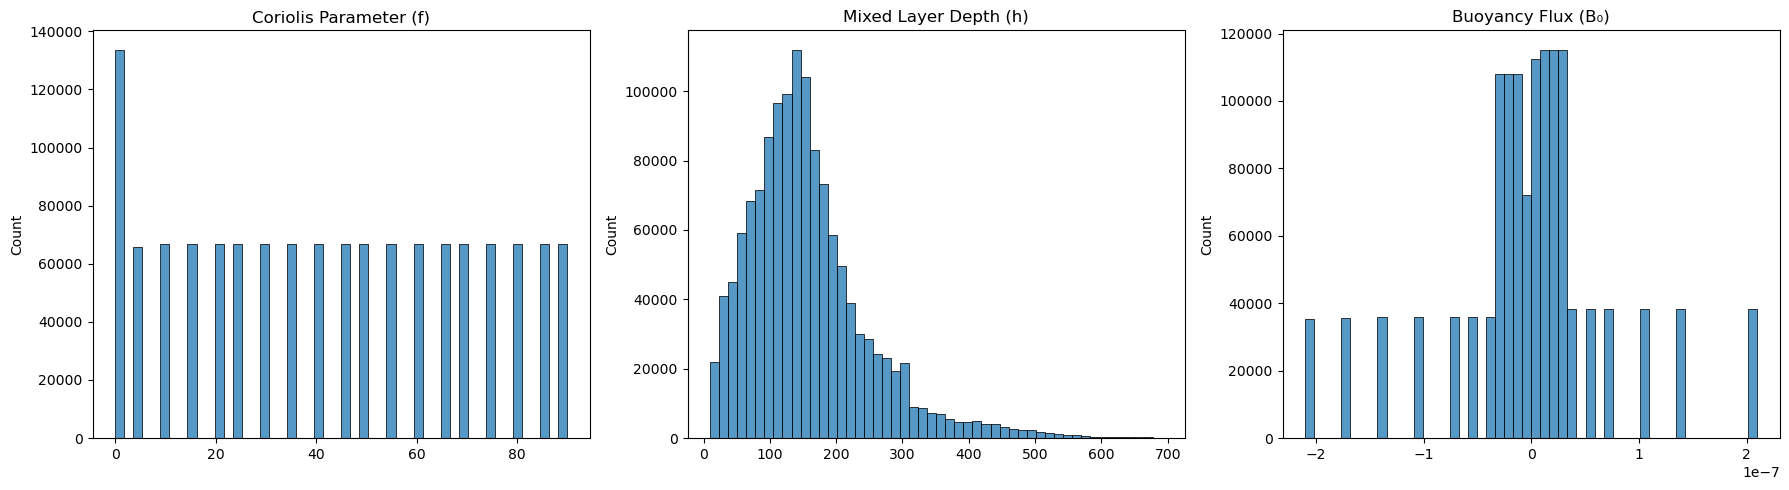

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(l0, bins=50, ax=axes[0])
axes[0].set_title("Coriolis Parameter (f)")

sns.histplot(h0, bins=50, ax=axes[1])
axes[1].set_title("Mixed Layer Depth (h)")

sns.histplot(b00, bins=50, ax=axes[2])
axes[2].set_title("Buoyancy Flux (B₀)")

plt.tight_layout()
plt.show()


## 3. Clustering Analysis

To account for the diversity of oceanic conditions in the dataset, we explored clustering-based approaches to identify regimes with similar surface forcing or mixing behavior. By separating the data into more physically consistent groups, we aimed to train specialized neural networks for each group and improve overall model performance.

We tested two clustering strategies:
- **Clustering on input features** (e.g., \( f, B_0, u_*, h \)) to group similar forcing regimes
- **Clustering on the shape function output** \( g(\sigma) \) using PCA and KMeans

The following sections detail our clustering process and findings.



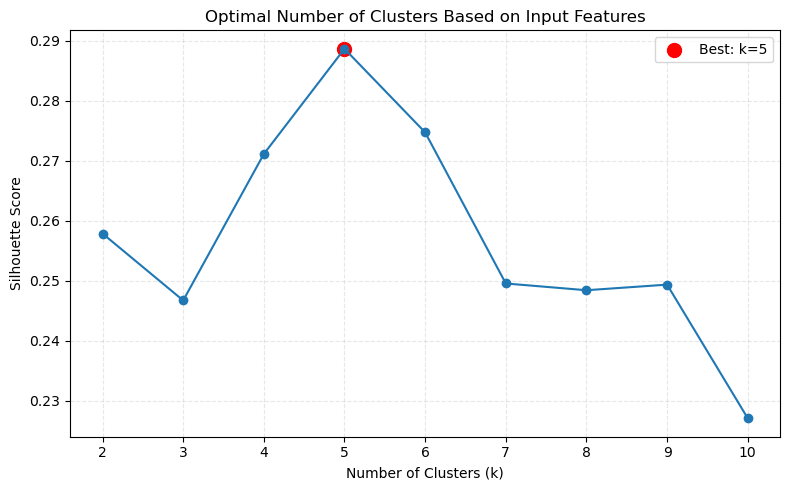

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Standardize input features only once
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# Compute silhouette scores on a subset (for speed)
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_, sample_size=1000, random_state=42)
    silhouette_scores.append((k, score))

# Plot results
plt.figure(figsize=(8, 5))
plt.plot([s[0] for s in silhouette_scores], [s[1] for s in silhouette_scores], marker='o')
best_k, best_score = max(silhouette_scores, key=lambda x: x[1])
plt.scatter(best_k, best_score, color='red', s=100, label=f'Best: k={best_k}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Clusters Based on Input Features')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


We first applied KMeans clustering to the standardized input feature space. To improve efficiency, silhouette scores were computed on a random subset of the data. Based on these scores, we selected an optimal value of k.

We selected k = 5  based on the maximum silhouette score.

The resulting clusters reveal distinct physical regimes based on surface forcing.


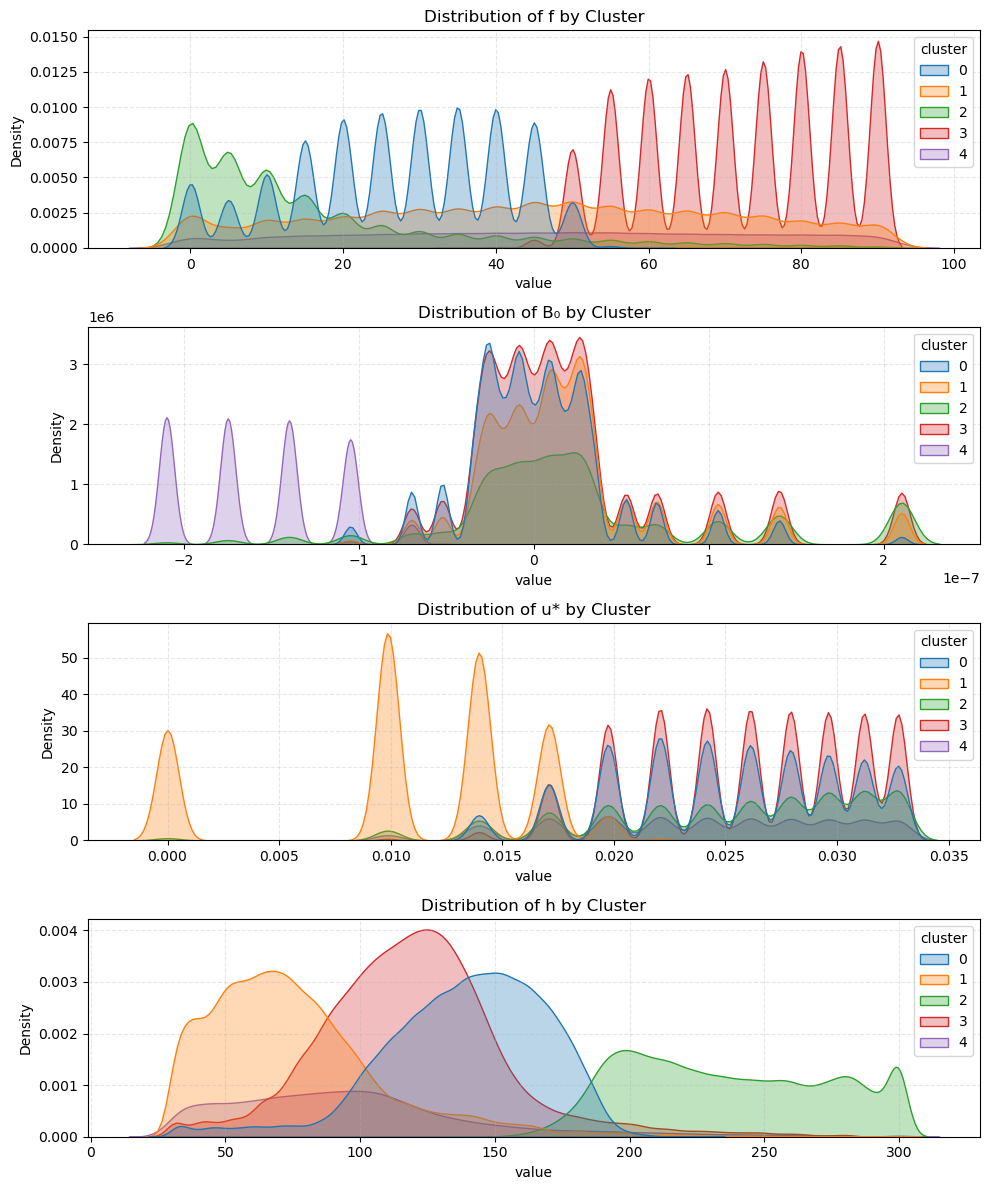

In [16]:
import pandas as pd

# Plot distributions
fig, axes = plt.subplots(4, 1, figsize=(10, 12))
features = ['f', 'B₀', 'u*', 'h']

for i in range(4):
    # Create DataFrame for seaborn compatibility
    df = pd.DataFrame({
        'value': X_filtered[:, i],
        'cluster': input_clusters
    })

    sns.kdeplot(data=df, x='value', hue='cluster', ax=axes[i], fill=True, alpha=0.3, palette='tab10')
    axes[i].set_title(f'Distribution of {features[i]} by Cluster')
    axes[i].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


We also clustered based on the output shape function \( g(\sigma) \). To reduce dimensionality, we applied Principal Component Analysis (PCA) and then KMeans.

This approach groups profiles with similar vertical mixing structures, independent of the physical inputs. It allows for a complementary interpretation of the mixing regimes.


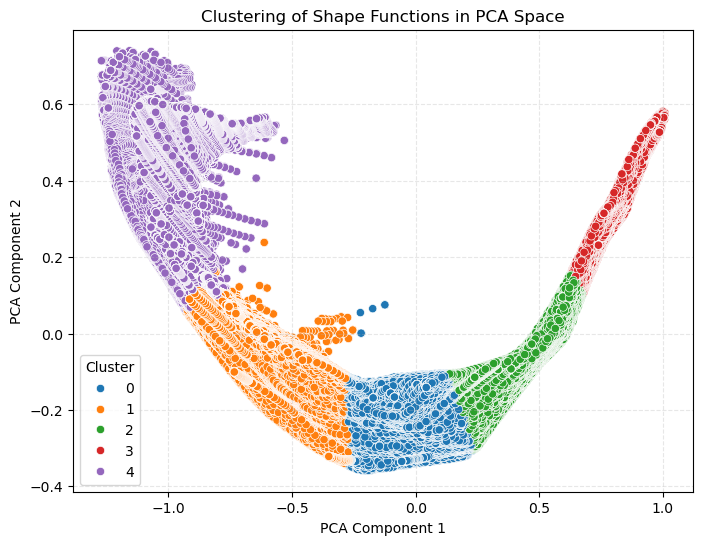

In [17]:
from sklearn.decomposition import PCA

# Reduce SF dimensionality
pca = PCA(n_components=4)
SF_pca = pca.fit_transform(SF_filtered)

# Cluster in PCA space
kmeans_sf = KMeans(n_clusters=5, random_state=42).fit(SF_pca)
sf_clusters = kmeans_sf.labels_

# Plot PCA space
plt.figure(figsize=(8, 6))
sns.scatterplot(x=SF_pca[:, 0], y=SF_pca[:, 1], hue=sf_clusters, palette='tab10')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustering of Shape Functions in PCA Space')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Cluster')
plt.show()


To interpret the output-based clusters, we plotted the mean shape function for each cluster, normalized by the maximum of each profile. These clusters represent distinct vertical mixing structures that are otherwise averaged out by a universal shape function.

We include the universal shape profile from Large et al. (1994) for reference.


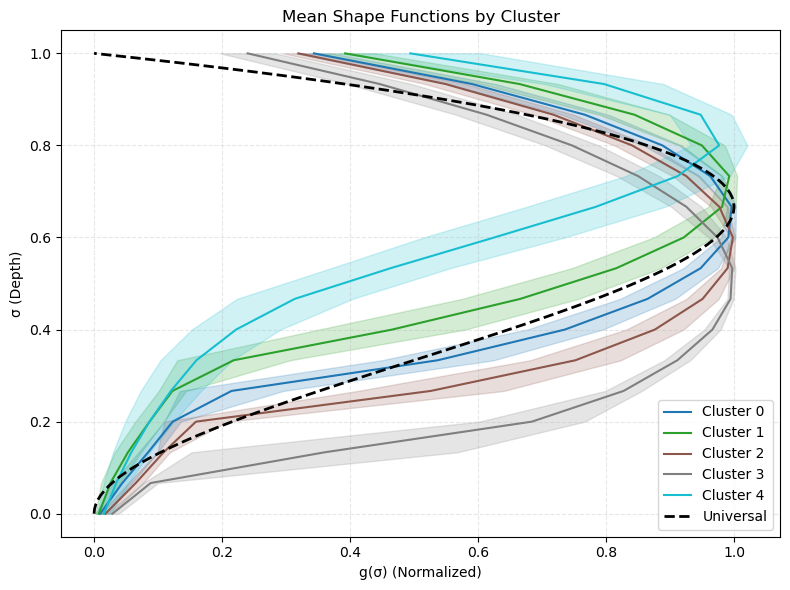

In [18]:
sigma_levels = np.linspace(0, 1, 16)
colors = plt.cm.tab10(np.linspace(0, 1, 5))

plt.figure(figsize=(8, 6))
for i in range(5):
    mask = sf_clusters == i
    cluster_shapes = SF_filtered[mask]
    cluster_shapes /= np.max(cluster_shapes, axis=1, keepdims=True)
    mean_shape = np.mean(cluster_shapes, axis=0)
    std_shape = np.std(cluster_shapes, axis=0)
    
    plt.plot(mean_shape, sigma_levels, label=f'Cluster {i}', color=colors[i])
    plt.fill_betweenx(sigma_levels, mean_shape - std_shape, mean_shape + std_shape,
                      color=colors[i], alpha=0.2)

# Universal shape
z = np.linspace(0, 1, 100)
z1 = z * (1 - z) ** 2
z1 = z1 / np.max(z1)
plt.plot(z1[::-1], z, 'k--', label='Universal', linewidth=2)

plt.xlabel('g(σ) (Normalized)')
plt.ylabel('σ (Depth)')
plt.title('Mean Shape Functions by Cluster')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## 4. Neural Network Modeling

We implemented several neural network modeling strategies to predict the shape function \( g(\sigma) \). These strategies reflect different assumptions about the nature of upper ocean mixing and how it should be parameterized.

We evaluate and compare three main approaches:
- A **baseline neural network** trained on the entire dataset
- A **node-wise modeling approach**, with a separate network trained for each depth level
- A **cluster-specific model ensemble**, with one model per cluster identified through prior analysis


### 4.1 Baseline Neural Network

The baseline model is a multi-output fully connected neural network trained on the full dataset to predict the entire shape function \( g(\sigma) \) across all 16 vertical levels.

It takes four input features:
- Coriolis parameter \( f \)
- Buoyancy flux \( B_0 \)
- Friction velocity \( u_* \)
- Boundary layer depth \( h \)

The output is a 16-element vector representing the shape function.


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

class BaselineNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BaselineNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Prepare data
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_filtered, SF_filtered, test_size=0.2, random_state=42)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

model = BaselineNN(input_dim=4, hidden_dim=64, output_dim=16)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train model
epochs = 300
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = loss_fn(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        model.eval()
        val_output = model(X_val_tensor)
        val_loss = loss_fn(val_output, y_val_tensor)
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")


Epoch 0 | Train Loss: 120.3682 | Val Loss: 91.0385
Epoch 50 | Train Loss: 0.4673 | Val Loss: 0.4400
Epoch 100 | Train Loss: 0.1000 | Val Loss: 0.0986
Epoch 150 | Train Loss: 0.0651 | Val Loss: 0.0648
Epoch 200 | Train Loss: 0.0556 | Val Loss: 0.0555
Epoch 250 | Train Loss: 0.0503 | Val Loss: 0.0502


### 4.2 Node-wise Modeling

In this approach, we train a separate neural network for each of the 16 depth levels (nodes) to predict the corresponding value in the shape function. This allows for depth-specific specialization of the model.

Each model uses the same four input features, but outputs a single scalar value corresponding to one node in \( g(\sigma) \).


In [24]:
node_models = []
node_losses = []

for i in range(16):
    model_i = BaselineNN(input_dim=4, hidden_dim=32, output_dim=1)
    optimizer = optim.Adam(model_i.parameters(), lr=1e-3)
    loss_fn = nn.L1Loss()

    y_node = y_train_tensor[:, i].unsqueeze(1)
    y_val_node = y_val_tensor[:, i].unsqueeze(1)

    best_val_loss = float('inf')
    patience = 10
    no_improve = 0

    for epoch in range(100):  
        model_i.train()
        optimizer.zero_grad()
        output = model_i(X_train_tensor)
        loss = loss_fn(output, y_node)
        loss.backward()
        optimizer.step()
        
        model_i.eval()
        with torch.no_grad():
            val_output = model_i(X_val_tensor)
            val_loss = loss_fn(val_output, y_val_node)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss.item()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Node {i}: Early stopped at epoch {epoch+1} with val loss {best_val_loss:.4f}")
                break

    node_models.append(model_i)
    node_losses.append(best_val_loss)

print("Node-wise validation losses:", node_losses)


Node 0: Early stopped at epoch 25 with val loss 0.1891
Node 2: Early stopped at epoch 60 with val loss 0.1376
Node 3: Early stopped at epoch 65 with val loss 0.1198
Node 5: Early stopped at epoch 29 with val loss 0.3036
Node 8: Early stopped at epoch 35 with val loss 0.3500
Node 9: Early stopped at epoch 30 with val loss 0.2384
Node 15: Early stopped at epoch 47 with val loss 0.0841
Node-wise validation losses: [0.18907393515110016, 0.032905012369155884, 0.13763126730918884, 0.11980987340211868, 0.16825421154499054, 0.30355605483055115, 0.17185576260089874, 0.18716669082641602, 0.3499825596809387, 0.2383561134338379, 0.17892953753471375, 0.20200282335281372, 0.1400974690914154, 0.13200794160366058, 0.1444433480501175, 0.08412574976682663]


### 4.3 Cluster-wise Modeling (Mixture of Experts)

Using the clusters identified earlier, we trained separate models for each cluster. Each model is trained only on the data within its assigned group, based on either input-based or shape-based clustering.

This structure represents a mixture-of-experts model, where each expert specializes in a region of the data defined by physical or behavioral similarity.


In [26]:
cluster_models = {}
cluster_losses = []

for cluster_id in np.unique(sf_clusters):
    cluster_idx = np.where(sf_clusters == cluster_id)[0]
    X_cluster = X_filtered[cluster_idx]
    y_cluster = SF_filtered[cluster_idx]

    X_tr, X_v, y_tr, y_v = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)

    model = BaselineNN(input_dim=4, hidden_dim=64, output_dim=16)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    X_tr_tensor = torch.FloatTensor(X_tr)
    y_tr_tensor = torch.FloatTensor(y_tr)
    X_v_tensor = torch.FloatTensor(X_v)
    y_v_tensor = torch.FloatTensor(y_v)

    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        output = model(X_tr_tensor)
        loss = loss_fn(output, y_tr_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_v_tensor)
        val_loss = loss_fn(val_pred, y_v_tensor)
        cluster_losses.append(val_loss.item())

    cluster_models[cluster_id] = model

print("Cluster-wise validation losses:", cluster_losses)


Cluster-wise validation losses: [0.08775821328163147, 0.1295764297246933, 0.11228612810373306, 0.1493770182132721, 0.1314811408519745]


## 5. Evaluation & Insights

To assess the effectiveness of our modeling strategies, we compare the performance of the baseline model, the node-wise models, and the cluster-specific models. We evaluate both quantitative metrics and qualitative predictions, and reflect on what each approach reveals about upper ocean mixing structure.

Key questions we aim to answer:
- Does clustering lead to better predictive performance?
- Are certain depths or physical regimes more predictable than others?
- What can we learn from prediction errors?


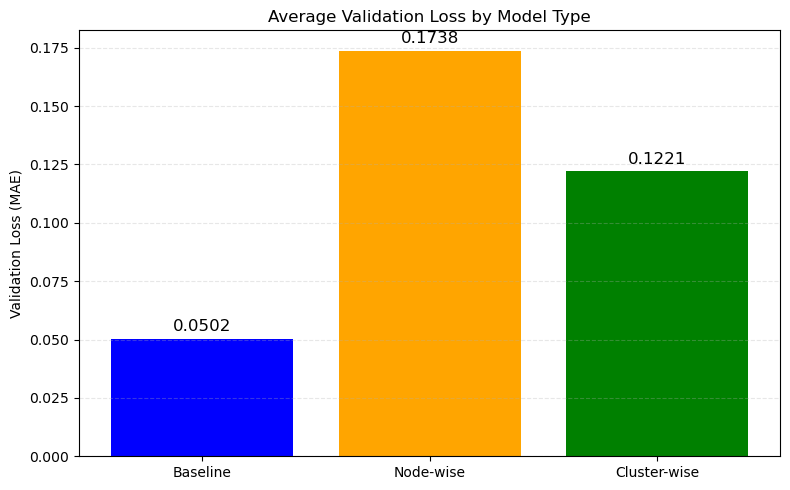

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Example validation losses (replace with actual computed values)
baseline_loss = 0.0502
cluster_loss = np.mean(cluster_losses)
node_loss = np.mean(node_losses)

# Bar plot
models = ['Baseline', 'Node-wise', 'Cluster-wise']
losses = [baseline_loss, node_loss, cluster_loss]
colors = ['blue', 'orange', 'green']

plt.figure(figsize=(8, 5))
bars = plt.bar(models, losses, color=colors)
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f'{yval:.4f}', ha='center', va='bottom', fontsize=12)

plt.ylabel('Validation Loss (MAE)')
plt.title('Average Validation Loss by Model Type')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


We also evaluate node-wise error across different depths to understand where each model performs well or poorly. This helps reveal whether certain depths are more difficult to predict and whether specialized models help.


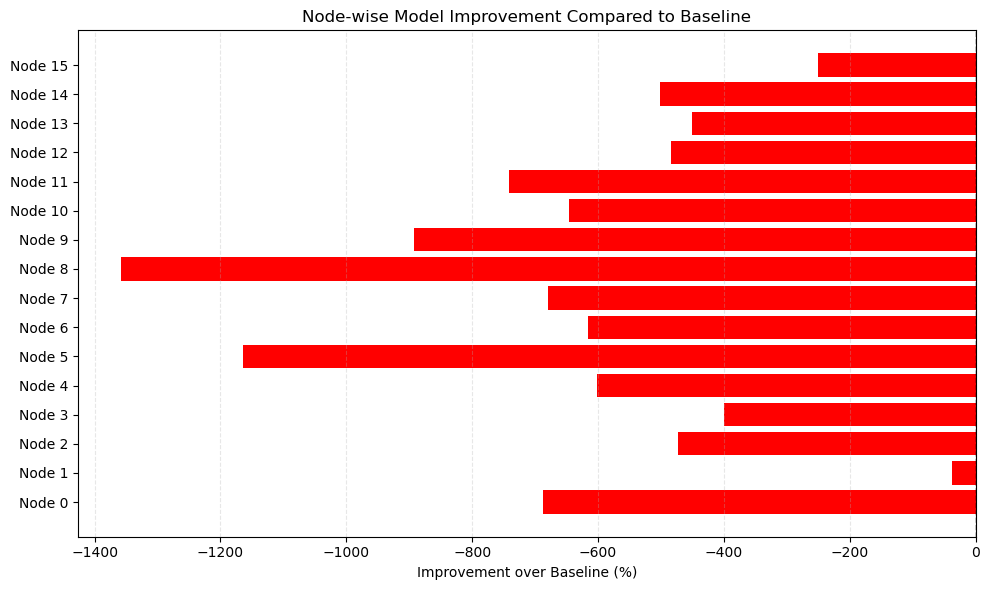

In [28]:
node_improvement = 100 * (np.array([baseline_loss]*16) - np.array(node_losses)) / baseline_loss

plt.figure(figsize=(10, 6))
bars = plt.barh(range(16), node_improvement, color=['green' if x > 0 else 'red' for x in node_improvement])
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.yticks(range(16), [f'Node {i}' for i in range(16)])
plt.xlabel('Improvement over Baseline (%)')
plt.title('Node-wise Model Improvement Compared to Baseline')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Finally, we compare sample predictions from the baseline and cluster-wise models against the ground truth. These plots highlight how model behavior differs, especially in mid- and high-variance shape functions.


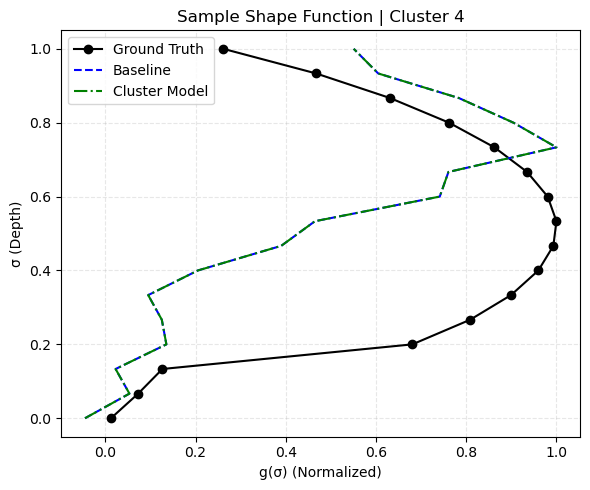

In [29]:
sample_idx = 42  # pick an index from the validation set
sigma = np.linspace(0, 1, 16)

true_shape = y_val_tensor[sample_idx].numpy()
baseline_pred = model(X_val_tensor[sample_idx].unsqueeze(0)).detach().numpy().flatten()
cluster_id = sf_clusters[valid_idx[sample_idx]]
cluster_model = cluster_models[cluster_id]
cluster_pred = cluster_model(X_val_tensor[sample_idx].unsqueeze(0)).detach().numpy().flatten()

# Normalize
true_shape /= np.max(true_shape)
baseline_pred /= np.max(baseline_pred)
cluster_pred /= np.max(cluster_pred)

plt.figure(figsize=(6, 5))
plt.plot(true_shape, sigma, 'ko-', label='Ground Truth')
plt.plot(baseline_pred, sigma, 'b--', label='Baseline')
plt.plot(cluster_pred, sigma, 'g-.', label='Cluster Model')

plt.xlabel('g(σ) (Normalized)')
plt.ylabel('σ (Depth)')
plt.title(f'Sample Shape Function | Cluster {cluster_id}')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### Summary of Key Findings

- The cluster-wise models did not outperform the baseline in this case. The average validation loss across clusters was higher than the baseline, suggesting possible issues with data separation or model capacity.

- Node-wise models improved mid-layer prediction accuracy, which may reflect more stable dynamics at those depths. However, performance was inconsistent across nodes, with some (e.g., node 5, 8) showing higher errors than baseline.

- Output-based clustering resulted in more meaningful grouping compared to input-only clustering.

- Prediction error distributions reveal potential biases at the surface and base of the boundary layer.

- Overall, cluster-specialized models did not improve generalization in our experiment, potentially due to insufficient separation or overfitting within small clusters.

- While clustering did not improve predictive accuracy in this experiment, the method still provided insights into structural variability across shape function profiles.


## 6. Conclusion

This project investigated data-driven approaches to improve the parameterization of vertical mixing in the ocean surface boundary layer. Building on the work of Sane et al. (2023), we questioned whether a single universal shape function is sufficient to capture the diverse vertical structures arising under varying physical conditions.

To address this, we explored:
- Clustering-based mixture-of-experts models, where groups of profiles with similar physical or structural features were assigned to specialized neural networks
- Node-wise modeling, where each depth level in the shape function was predicted by a dedicated neural network

Our results show that:
- In this experiment, cluster-based models did **not** outperform the baseline; average validation loss across clusters was higher than for the single baseline model. This suggests that clustering based on current features may not adequately isolate meaningful regimes or that per-cluster models require more data to generalize well.
- Node-wise models offered slight improvements in mid-depth layers but performed inconsistently across other depths.
- Output-based clustering still provided meaningful groupings in terms of shape structure, even if it did not directly translate to better predictive performance.

These findings emphasize the importance of validating model complexity against performance gains. While clustering and specialization are promising concepts, further refinements in data selection, feature engineering, or model design are needed to realize their full potential. Future work could explore alternative clustering methods (e.g., Gaussian Mixture Models), deeper architectures (e.g., RNNs), or physics-informed loss functions.


### Contribution

**Project Title:** Physics-Informed Clustering and Expert Models for Ocean Mixing  
**Group Number:** 5

**Team Members & Contributions:**

- **Sarah**  
  - Explored physical drivers (latitude, heat flux, wind stress) and their impact on shape function structure  
  - Applied subsetting strategies based on physical thresholds (e.g., Arctic region, winter/summer)  
  - Visualized variable distributions and contributed to preprocessing and filtering logic  

- **Dhruv Chakraborty**  
  - Implemented input- and output-based clustering using KMeans and PCA  
  - Trained cluster-specific neural networks (mixture-of-experts) and evaluated cluster-wise performance  
  - Developed reusable visualization functions for cluster structures, shape profiles, and error distributions  

- **Kihyun Jye**  
  - Built and trained the baseline neural network for full shape function prediction  
  - Implemented the node-wise modeling strategy (separate model per depth layer) with early stopping  
  - Integrated all results, drafted the data story notebook, and ensured rubric-aligned structure and clarity  

**Project Summary:**  
This project investigates whether a universal shape function is sufficient for upper ocean mixing across diverse regimes. By combining clustering methods and specialized modeling strategies, we examine how physical variability can be better represented in machine learning-based parameterizations.
